# Experiments and results

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_theme(style='white')

# just for checking the data:
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
import umap
import cobra

import pickle

### 1) Load and preprocess the necessary datasets

To load the four necessary datasets, first download them using the following links:

* mRNA0.csv  (original  mRNA data) : https://drive.google.com/file/d/1QQiPBxWf1h-Klr8FDmVS2hH2RHf2obT1/view?usp=sharing

* mRNA.csv (processed mRNA data) : https://drive.google.com/file/d/1knxmHTYj_aKf9zd0glEWNRTVWcXV_3NX/view?usp=sharing

* gpr_results.csv (GPR-based reaction flux estimations) : https://drive.google.com/file/d/1FW1NmuSrVNkSB6YZKN3KlZGRpdGHD7Um/view?usp=sharing

* lin_prog_results.csv (LP-based reaction flux estimations) : https://drive.google.com/file/d/1c32nJL_h1wZEBw6W4rynuiZenIzqgVYQ/view?usp=sharing

In [5]:
# Load the datasets rna, gpr, lin:
rna0= pd.read_csv('data/preprocessing_results/mRNA0.csv' , index_col='Gene')
rna = pd.read_csv('data/preprocessing_results/mRNA.csv', index_col='Gene')
gpr = pd.read_csv('data/preprocessing_results/gpr_results.csv', index_col='Reaction')
lin = pd.read_csv('data/preprocessing_results/lin_prog_results.csv', index_col='Reaction')

# Transpose the datasets:
rna0= pd.DataFrame(rna0.T.to_numpy(),index=list(rna0.columns),columns=list(rna0.index))
rna = pd.DataFrame(rna.T.to_numpy(), index=list(rna.columns), columns=list(rna.index))
gpr = pd.DataFrame(gpr.T.to_numpy(), index=list(gpr.columns), columns=list(gpr.index))
lin = pd.DataFrame(lin.T.to_numpy(), index=list(lin.columns), columns=list(lin.index))

#Preprocess the dataset lin
lin_0 = lin.copy()
lin = lin.loc[:, lin.std() > 10]
lin = lin.loc[:, lin.quantile(q=0.9  , axis=0) > 0.5]

# Reorder the rows of the datasets using a random permutation PMT:
PMT = np.arange(len(list(rna.index)))      # 0, 1, ..., num_cells
np.random.seed(0)
np.random.shuffle(PMT)
rna0 = rna0.iloc[PMT]
rna = rna.iloc[PMT]
gpr = gpr.iloc[PMT]
lin_0 = lin_0.iloc[PMT]
lin = lin.iloc[PMT]

# Merge the three datasets:
mer = pd.concat([rna, gpr, lin], axis=1)

# Print the shapes of the datasets: (num_cells, num_attributes)
print('rna0 shape before preprocessing: (' + str(rna0.shape[0]) + ', '   + str(rna0.shape[1]) + ')')      # (7827, 26069)
print('rna  shape before preprocessing: (' + str(rna.shape[0])  + ',  '  +  str(rna.shape[1]) + ')')      # (7827,  7750)
print('gpr  shape before preprocessing: (' + str(gpr.shape[0])  + ',   ' +  str(gpr.shape[1]) + ')')      # (7827,   779)
print('lin  shape before preprocessing: (' + str(lin.shape[0])  + ',   ' +  str(lin.shape[1]) + ')')      # (7827,   631)
print('mer  shape before preprocessing: (' + str(mer.shape[0])  + ',  '  +  str(mer.shape[1]) + ')')      # (7827,  9160)

# print('\n----------------------------------\n')

# load y: open .\data\cell_types_from_CellMarker.txt in order to get the TYPES OF CELLS = y
cell_types = {}
with open('data\cell_types_from_CellMarker.txt', 'r') as read_file:
    for line in read_file.readlines():
        line = line.split()
        cell = line[0]
        cell_type = ' '.join(line[4:])
        cell_types[cell] = cell_type

for cell in list(rna.index):
    if cell not in cell_types.keys():
        cell_types[cell] = 'Unsure'
        

# print('Number of cells in the data:', len(cell_types.keys()))

# Make a colour map
unique_cell_types = np.unique(list(cell_types.values()))
unique_colours = {cell_type:i for i, cell_type in enumerate(unique_cell_types)}
cell_types_list = [cell_types[cell] for cell in list(rna.index)]
cell_type_code_list = [unique_colours[cell_type] for cell_type in cell_types_list]    # y = cell_type_code_list
colours = [unique_colours[cell_type] for cell_type in cell_types_list]
y = np.array([[unique_colours[cell_types[cell]]] for cell in list(rna.index)])
y = pd.DataFrame(y, index=list(rna.index), columns=['Cell Type code'])
print('\nNum.  of each type:', {typ:sum([unique_colours[typ]==el2 for el2 in colours]) for typ in unique_colours.keys()}, '\n')

# Remove cells for which the biologists were 'Unsure':
inds = np.array(list(y['Cell Type code']!=unique_colours['Unsure']))
colours = [c for i, c in enumerate(colours) if inds[i]==True]
cell_types_list = [t for i, t in enumerate(cell_types_list) if inds[i]==True]
rna0= rna0.loc[inds]
rna = rna.loc[inds]
gpr = gpr.loc[inds]
lin_0 = lin_0.loc[inds]
lin = lin.loc[inds]
mer = mer.loc[inds]
y   =   y.loc[inds]

# Print the shapes of the datasets:
# print(len(colours))
print('rna0 shape: (' + str(rna0.shape[0]) + ', '    + str(rna0.shape[1]) + ')')      # (7210, 26069)
print('rna  shape: (' + str(rna.shape[0]) + ',  '     + str(rna.shape[1]) + ')')      # (7827, 7750)
print('gpr  shape: (' + str(gpr.shape[0]) + ',   '    + str(gpr.shape[1]) + ')')      # (7210,  779)
print('lin  shape: (' + str(lin.shape[0]) + ',   '    + str(lin.shape[1]) + ')')      # (7210,  631)
print('mer  shape: (' + str(mer.shape[0]) + ',  '     + str(mer.shape[1]) + ')')      # (7210, 9160)
print('y    shape: (' + str(  y.shape[0]) + ',     '  + str(  y.shape[1]) + ')')      # (7210,    1)

# print(y)

rna0 shape before preprocessing: (7827, 26069)
rna  shape before preprocessing: (7827,  7750)
gpr  shape before preprocessing: (7827,   779)
lin  shape before preprocessing: (7827,   631)
mer  shape before preprocessing: (7827,  9160)

Num.  of each type: {'Basal cell': 131, 'CD8+ T cell': 1605, 'Cancer cell': 1235, 'Endothelial cell': 1253, 'Fibroblast': 1125, 'Luminal epithelial cell': 898, 'M1 macrophage': 96, 'Myeloid cell': 240, 'Stem cell': 627, 'Unsure': 617} 

rna0 shape: (7210, 26069)
rna  shape: (7210,  7750)
gpr  shape: (7210,   779)
lin  shape: (7210,   631)
mer  shape: (7210,  9160)
y    shape: (7210,     1)


### 2) Explore the datasets

In [3]:
# Check that the order of cells in the index is the same.
print(np.all(list(rna.index) == list(rna0.index)))   # True
print(np.all(list(rna.index) == list(gpr.index)))    # True
print(np.all(list(rna.index) == list(lin.index)))    # True
print(np.all(list(rna.index) == list(mer.index)))    # True
print(np.all(list(rna.index) == list(y.index)))      # True

True
True
True
True
True


In [4]:
# do PCA, then UMAP - rna0:

# they chose 20 components in the paper:  

def PCA_UMAP_project(dataset, name, n_comps=100, rand_seed=0):
    pca = PCA(n_components=n_comps, random_state=rand_seed)  
    X = pca.fit_transform(dataset.to_numpy())
    umap_reducer = umap.UMAP(random_state=rand_seed)
    umap_embeddings = umap_reducer.fit_transform(X).T
    # Plot the embeddings:
    plt.figure(1, figsize=(6, 5))
    scatter = plt.scatter(umap_embeddings[0, :], umap_embeddings[1, :], s=3, c=colours, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('PCA + UMAP projection of ' + name + ' data', fontsize=15)
    plt.legend(handles=scatter.legend_elements(num=list(np.unique(colours)))[0], labels=unique_colours, title='Cell type',
              loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('imgs/pca_umap_' + name.replace(' ', '_') + '.pdf', bbox_inches='tight')
    plt.show()
    return

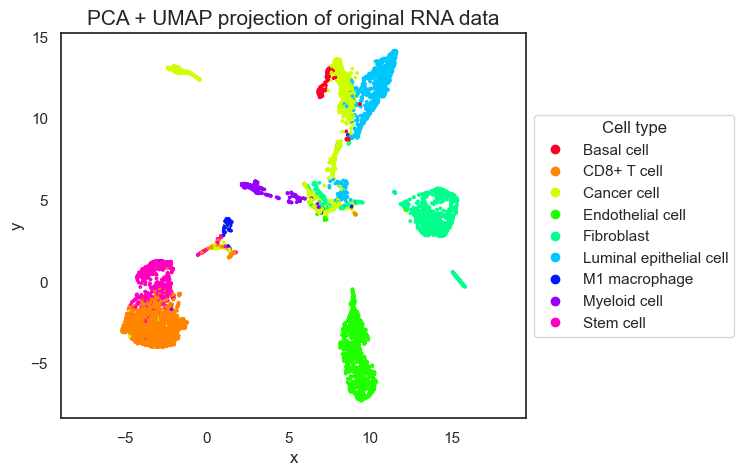

In [5]:
PCA_UMAP_project(rna0, 'original RNA', n_comps=100)

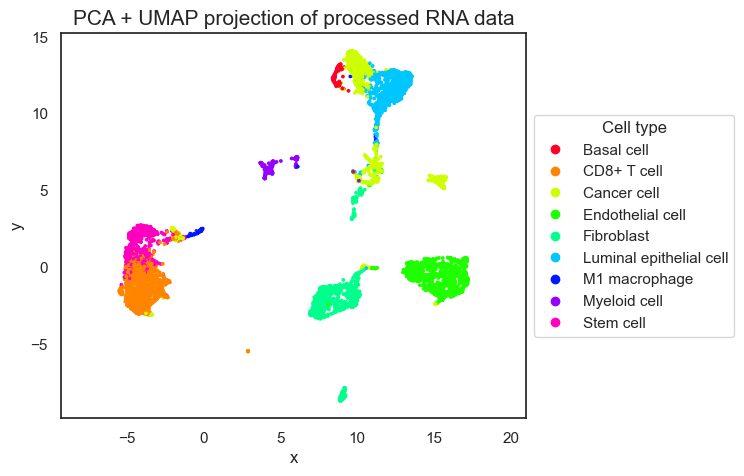

In [6]:
PCA_UMAP_project(rna, 'processed RNA', n_comps=100)

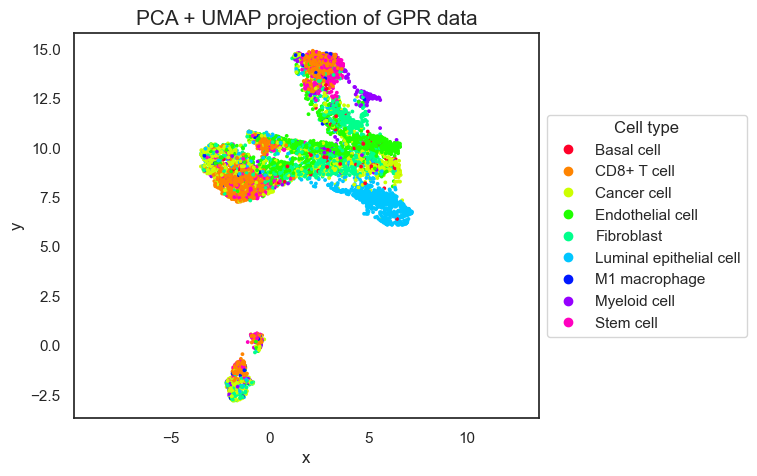

In [7]:
PCA_UMAP_project(gpr, 'GPR', n_comps=100)

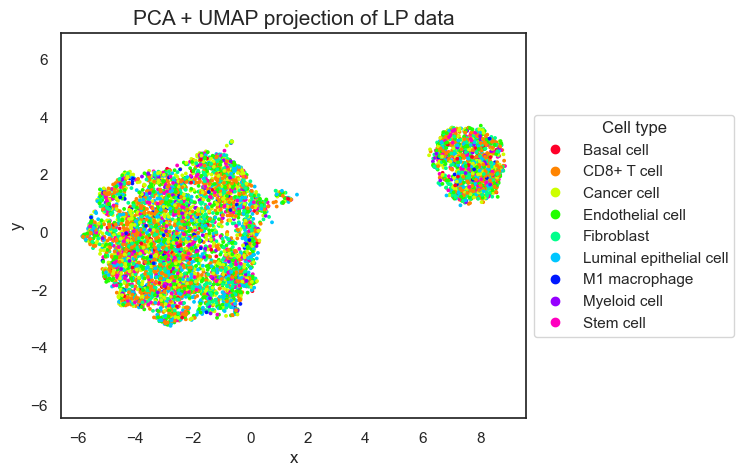

In [8]:
PCA_UMAP_project(lin, 'LP', n_comps=100)

#### LDA:

In [9]:
def LDA_project(dataset, name, cell_type_dict=cell_types):
    cell_types_list = [cell_type_dict[cell] for cell in list(rna.index)]
    lda = LDA(n_components=2)
    lda_X = lda.fit_transform(dataset.to_numpy(), y=cell_types_list)
    plt.figure(2, figsize=(7, 5))
    scatter = plt.scatter(lda_X[:, 0], lda_X[:, 1], s=3, c=colours, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('LDA projection of ' + name + ' data', fontsize=15)
    plt.legend(handles=scatter.legend_elements(num=list(np.unique(colours)))[0], labels=unique_colours, title='Cell type',
              loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('imgs/lda_' + name.replace(' ', '_') + '.pdf', bbox_inches='tight')
    plt.show()
    return

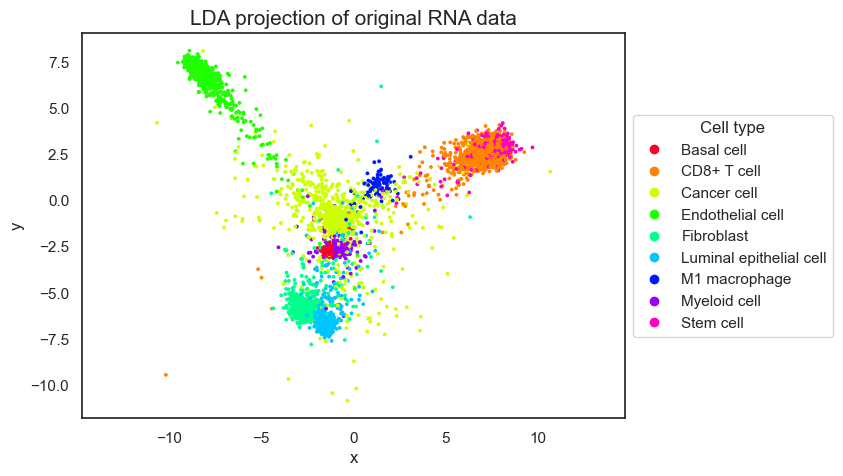

In [10]:
LDA_project(rna0, 'original RNA', cell_type_dict=cell_types)

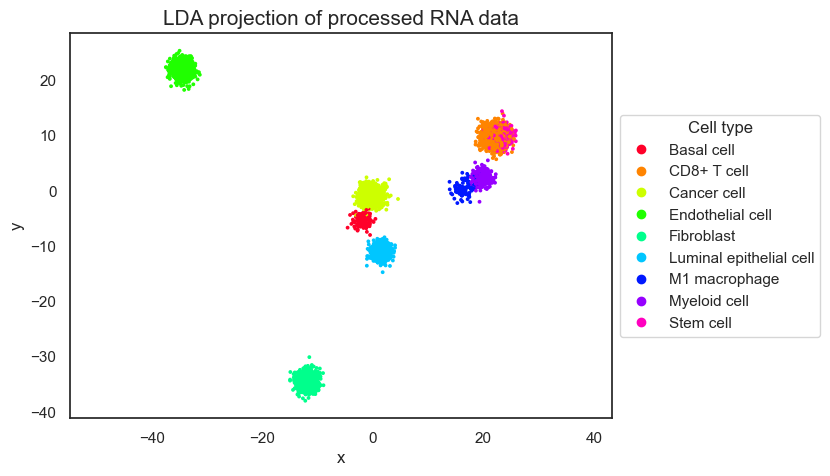

In [11]:
LDA_project(rna,  'processed RNA', cell_type_dict=cell_types)

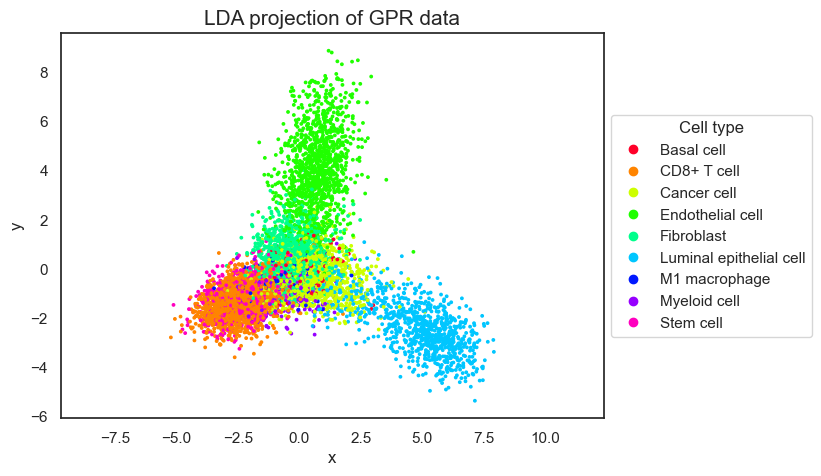

In [12]:
LDA_project(gpr,  'GPR', cell_type_dict=cell_types)

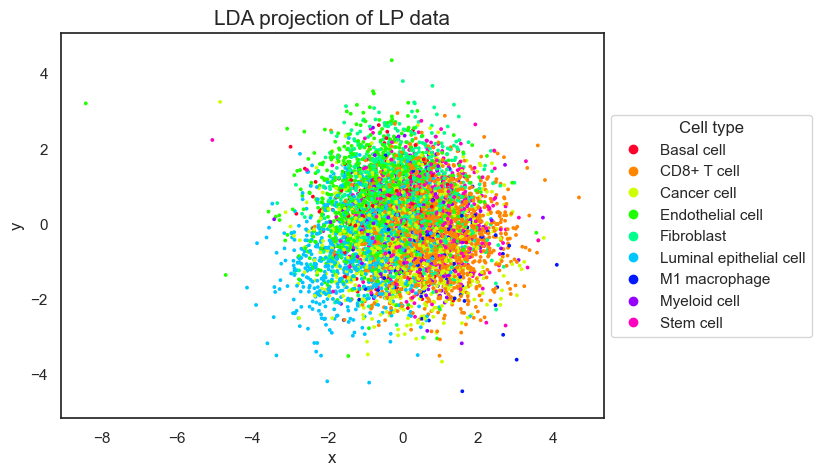

In [13]:
LDA_project(lin,  'LP', cell_type_dict=cell_types)

## 3) Classification with Random Forest:

### 3.1) Split into the training/testing sets

(Note that there are 100 trees in each forest)

In [14]:
def get_score(preds, correct):
    return sum((preds==correct)*1)/len(correct)

def RF_train_and_test(data, y, train_inds, test_inds, rand_seed=0):
    y_train =  y.to_numpy().flatten()[train_inds]
    y_test  =  y.to_numpy().flatten()[test_inds]
    data_train = data.iloc[train_inds]
    data_test  = data.iloc[test_inds]
    rf = RandomForestClassifier(max_depth=None, criterion='entropy', random_state=rand_seed)   
    rf.fit(data_train, y_train)
    imp = rf.feature_importances_
    pred = rf.predict(data_test)
    score = get_score(pred, y_test)
    return pred, imp, score 


rna0_preds  = []
rna0_imps   = []
rna0_scores = []

rna_preds  = []
rna_imps   = []
rna_scores = []

gpr_preds  = []
gpr_imps   = []
gpr_scores = []

lin_preds  = []
lin_imps   = []
lin_scores = []

mer_preds  = []
mer_imps   = []
mer_scores = []

  
kf = KFold(n_splits=10)
for i, (train_inds, test_inds) in enumerate(kf.split(rna)):
    print(f"Fold {i+1}")
    
    rna0_pred, rna0_imp, rna0_score = RF_train_and_test(rna0, y, train_inds, test_inds)
    rna0_imps.append(rna0_imp)
    rna0_preds.append(rna0_pred)
    rna0_scores.append(rna0_score)
                                                         
    rna_pred, rna_imp, rna_score = RF_train_and_test(rna, y, train_inds, test_inds)
    rna_preds.append(rna_pred)
    rna_imps.append(rna_imp)
    rna_scores.append(rna_score)
    
    gpr_pred, gpr_imp, gpr_score = RF_train_and_test(gpr, y, train_inds, test_inds)
    gpr_preds.append(gpr_pred)
    gpr_imps.append(gpr_imp)
    gpr_scores.append(gpr_score)
    
    lin_pred, lin_imp, lin_score = RF_train_and_test(lin, y, train_inds, test_inds)
    lin_preds.append(lin_pred)
    lin_imps.append(lin_imp)
    lin_scores.append(lin_score)
    
    mer_pred, mer_imp, mer_score = RF_train_and_test(mer, y, train_inds, test_inds)
    mer_preds.append(mer_pred)
    mer_imps.append(mer_imp)
    mer_scores.append(mer_score)

rna0_preds = np.array(rna0_preds)
rna_preds  = np.array(rna_preds)
gpr_preds  = np.array(gpr_preds)
lin_preds  = np.array(lin_preds)
mer_preds  = np.array(mer_preds)

rna0_imps = np.array(rna0_imps)
rna_imps  = np.array(rna_imps)
gpr_imps  = np.array(gpr_imps)
lin_imps  = np.array(lin_imps)
mer_imps  = np.array(mer_imps)

rna0_scores = np.array(rna0_scores)
rna_scores  = np.array(rna_scores)
gpr_scores  = np.array(gpr_scores)
lin_scores  = np.array(lin_scores)
mer_scores  = np.array(mer_scores)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [15]:
# Save the results:
final_predictions = (rna0_preds , rna_preds , gpr_preds , lin_preds , mer_preds)
final_imps        = (rna0_imps  , rna_imps  , gpr_imps  , lin_imps  , mer_imps)
final_scores      = (rna0_scores, rna_scores, gpr_scores, lin_scores, mer_scores)

f = open('results/predictions.pckl', 'wb')
pickle.dump(final_predictions, f)
f.close()

f = open('results/featureImportances.pckl', 'wb')
pickle.dump(final_imps, f)
f.close()

f = open('results/scores.pckl', 'wb')
pickle.dump(final_scores, f)
f.close()

In [16]:
# Load the results:

f = open('results/predictions.pckl', 'rb')
final_predictions = pickle.load(f)
f.close()

f = open('results/featureImportances.pckl', 'rb')
final_imps = pickle.load(f)
f.close()

f = open('results/scores.pckl', 'rb')
final_scores = pickle.load(f)
f.close()

rna0 score mean: 0.91387 , standard deviation: 0.00535
rna  score mean: 0.9276 , standard deviation: 0.00796
gpr  score mean: 0.77698 , standard deviation: 0.01582
lin  score mean: 0.42746 , standard deviation: 0.02336
mer  score mean: 0.92455 , standard deviation: 0.00844


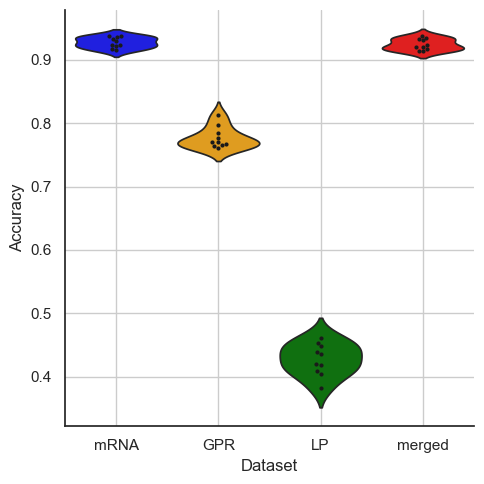

In [17]:
rna0_scores, rna_scores, gpr_scores, lin_scores, mer_scores = final_scores
num_split = 10

rna0_score_mean = np.mean(rna0_scores)
rna0_score_std  = np.std(rna0_scores)
print('rna0 score mean:', round(rna0_score_mean, 5), ', standard deviation:', round(rna0_score_std, 5))

rna_score_mean = np.mean(rna_scores)
rna_score_std  = np.std(rna_scores)
print('rna  score mean:', round(rna_score_mean, 5), ', standard deviation:', round(rna_score_std, 5))

gpr_score_mean = np.mean(gpr_scores)
gpr_score_std  = np.std(gpr_scores)
print('gpr  score mean:', round(gpr_score_mean, 5), ', standard deviation:', round(gpr_score_std, 5))

lin_score_mean = np.mean(lin_scores)
lin_score_std  = np.std(lin_scores)
print('lin  score mean:', round(lin_score_mean, 5), ', standard deviation:', round(lin_score_std, 5))

mer_score_mean = np.mean(mer_scores)
mer_score_std = np.std(mer_scores)
print('mer  score mean:', round(mer_score_mean, 5), ', standard deviation:', round(mer_score_std, 5))

# Create score dataframes
dataset_column = np.array(['mRNA']*num_split + ['GPR']*num_split + ['LP']*num_split + ['merged']*num_split)
score_column   = np.concatenate((rna_scores, gpr_scores, lin_scores, mer_scores))
plot_dataframe = pd.DataFrame({'Dataset': dataset_column, 'Accuracy': score_column})

# Define color palette for each dataset
palette = {'mRNA': 'blue', 'GPR': 'orange', 'LP': 'green', 'merged': 'red'}

# plot the diagram:
sns.set_theme(style='white')
cat = sns.catplot(data=plot_dataframe, x='Dataset', y='Accuracy', hue='Dataset', kind='violin', inner=None, palette=palette)
sns.swarmplot(    data=plot_dataframe, x='Dataset', y='Accuracy', color='k', size=3, ax=cat.ax)
plt.grid(True)
plt.savefig('imgs/violin.pdf', bbox_inches='tight')
plt.show()

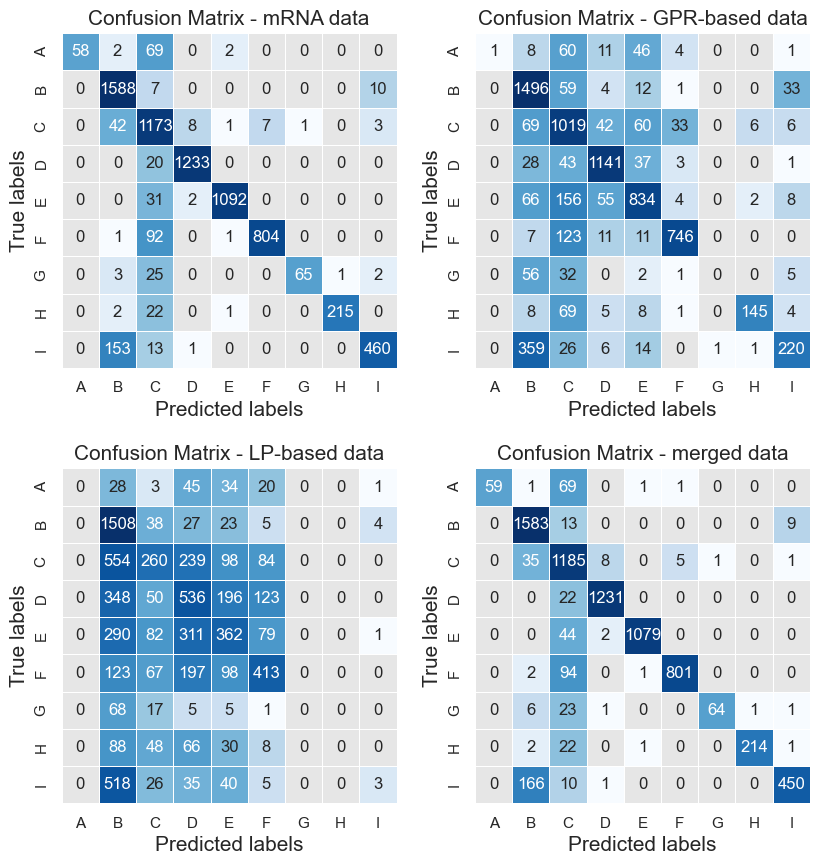

In [18]:
# Analysis of confusion matrices:

def get_confusion_matrix(preds, correct):
    confusion_matrix = np.zeros(shape=(9, 9), dtype=int)
    for prediction, answer in zip(preds, correct):
        confusion_matrix[answer, prediction] += 1
    return confusion_matrix

y_flat = y.to_numpy().flatten()
rna_conf_mat = get_confusion_matrix(rna_preds.flatten(), y_flat)
gpr_conf_mat = get_confusion_matrix(gpr_preds.flatten(), y_flat)
lin_conf_mat = get_confusion_matrix(lin_preds.flatten(), y_flat)
mer_conf_mat = get_confusion_matrix(mer_preds.flatten(), y_flat)
conf_matrices = [rna_conf_mat, gpr_conf_mat, lin_conf_mat, mer_conf_mat]

class_symbols = {'A': 'Basal cell', 
                 'B': 'CD8+ T cell', 
                 'C': 'Cancer cell', 
                 'D': 'Endothelial cell', 
                 'E': 'Fibroblast', 
                 'F': 'Luminal epithelial cell', 
                 'G': 'M1 macrophage', 
                 'H': 'Myeloid cell', 
                 'I': 'Stem cell'}


sns.set(font_scale=1.0) 
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
my_cmap = copy.copy(matplotlib.colormaps.get_cmap('Blues'))
my_cmap.set_bad((0.9, 0.9, 0.9))
names_of_confusion_matrices = ['mRNA data', 'GPR-based data', 'LP-based data', 'merged data']

for i in range(2):
    for j in range(2):
        ind = 2*i+j
        heatmap = sns.heatmap(conf_matrices[ind], annot=True, fmt="d", cmap=my_cmap, linewidths=.5, square=True, cbar=False,
                  xticklabels=class_symbols.keys(), yticklabels=class_symbols.keys(), ax=axes[i, j], norm=LogNorm())
        axes[i, j].set_xlabel('Predicted labels', fontsize=15)
        axes[i, j].set_ylabel('True labels', fontsize=15)
        axes[i, j].set_title(f'Confusion Matrix - {names_of_confusion_matrices[ind]}', fontsize=15)

# Create a legend for class symbols
legend_labels = [f'{symbol}: {explanation}' for symbol, explanation in class_symbols.items()]

# heatmap.legend(labels=legend_labels, title='Class Symbols', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=-0.2, hspace=0.3)
plt.savefig('imgs/confMatrices.pdf', bbox_inches='tight')
plt.show()

In [19]:
# Extract feature importances
rna0_imps, rna_imps, gpr_imps, lin_imps, mer_imps = final_imps


rna_imp_pairs = list(zip(rna.columns, np.mean(rna_imps, axis=0)))
rna_imp_pairs.sort(key=lambda x: x[1], reverse=True)
rna_imp_pairs = pd.DataFrame(rna_imp_pairs, columns=['Gene', 'Importance'])

gpr_imp_pairs = list(zip(gpr.columns, np.mean(gpr_imps, axis=0)))
gpr_imp_pairs.sort(key=lambda x: x[1], reverse=True)
gpr_imp_pairs = pd.DataFrame(gpr_imp_pairs, columns=['Reaction', 'Importance'])

lin_imp_pairs = list(zip(lin.columns, np.mean(lin_imps, axis=0)))
lin_imp_pairs.sort(key=lambda x: x[1], reverse=True)
lin_imp_pairs = pd.DataFrame(lin_imp_pairs, columns=['Reaction', 'Importance'])

mer_imp_pairs = list(zip(mer.columns, np.mean(mer_imps, axis=0)))
mer_imp_pairs.sort(key=lambda x: x[1], reverse=True)
mer_imp_pairs = pd.DataFrame(mer_imp_pairs, columns=['Attribute', 'Importance'])

print('Done')

Done


In [20]:
# gpr_imp_pairs.head(20)

gem1 = cobra.io.read_sbml_model('GEM\Human-GEM.xml')
print('Succesfully read the Human-GEM model.')

# translate all gene names into symbols:
gem1_gene_symbols = []
gem1_gene_dict_special_cases = {'ENSG00000100101':'V9GYY5', 'ENSG00000255730':'F5H5P2'      , 'ENSG00000259916':'AQP7B', 
    'ENSG00000272916':'S4R438', 'ENSG00000284844':'TOMT'  , 'ENSG00000285043':'LOC112694756', 'ENSG00000285269':'A0A2R8Y5X9'}
gem1_ensg_to_symbol = {}
gem1_symbol_to_ensg = {}
with open('GEM\Human-GEM_genes.tsv', 'r') as read_file:
    line = read_file.readline().split()[4]
    for line in read_file.readlines():
        line_split = line.split()
        ensg = line_split[0].replace('"', '')
        symbol = line_split[4].replace('"', '')
        if ensg in gem1_gene_dict_special_cases.keys():
            symbol = gem1_gene_dict_special_cases[ensg]
        gem1_gene_symbols.append(symbol)
        gem1_ensg_to_symbol[ensg] = symbol
        gem1_symbol_to_ensg[symbol] = ensg

print('GEM1 genes:', len(gem1_gene_symbols))   # Successfully translated all of them

Succesfully read the Human-GEM model.
GEM1 genes: 3068


In [21]:
# rna_imp_pairs.head(20)
# gpr_imp_pairs.head(20)
# lin_imp_pairs.head(20)

In [22]:
mer_imp_pairs.iloc[0:50,:]

,Attribute,Importance
0,CD3D,0.013861
1,IGFBP7,0.010893
2,CD7,0.009605
3,CD74,0.009095
4,HLA-DRB1,0.008342
5,HLA-DRA,0.008237
6,BTG1,0.008195
7,SPARCL1,0.008124
8,CALD1,0.007714
9,ECSCR.1,0.007055


In [23]:
mer_imp_pairs.iloc[50:100,:]

,Attribute,Importance
50,ACPP,0.003419
51,RAMP2,0.003383
52,LRRC26,0.003286
53,TAGLN,0.003275
54,MAP1B,0.003238
55,PCAT19,0.003183
56,ENG,0.003181
57,HLA-DPB1,0.003104
58,PTPRC,0.003063
59,ARHGDIB,0.003046


In [24]:
# Number of GEM genes present in the merged / rna dataset:
mer_gene_symbols = mer_imp_pairs[['Attribute']].to_numpy().flatten()   # ordered
rna_gene_symbols = rna_imp_pairs[['Gene']].to_numpy().flatten()   # ordered
total_GEM_matches = len([gene for gene in gem1_gene_symbols if gene in mer_gene_symbols])
print('Total GEM genes:', total_GEM_matches)

# get percent of non GEM genes in set of top x attributes
top_x_list = [10, 20, 50, 100, 200, 1000, len(mer_gene_symbols)]
for top_x in top_x_list:
    top_x_genes = mer_gene_symbols[0:top_x]
    num_rna = [gene for gene in rna_gene_symbols if gene in top_x_genes]
    num_GEM = [gene for gene in gem1_gene_symbols if gene in top_x_genes]
    print('\nNum GEM genes:', len(num_GEM), '/', top_x, ('(' + str(round(100*len(num_GEM) / top_x, 3)) + '%)'))
    print('Num genes:    ', len(num_rna), '/', top_x, ('(' + str(round(100*len(num_rna) / top_x, 3)) + '%)'))
    print('sum(importances):', round(sum(mer_imp_pairs[['Importance']].to_numpy().flatten()[0:top_x]), 3))

Total GEM genes: 1349

Num GEM genes: 0 / 10 (0.0%)
Num genes:     10 / 10 (100.0%)
sum(importances): 0.091

Num GEM genes: 1 / 20 (5.0%)
Num genes:     20 / 20 (100.0%)
sum(importances): 0.151

Num GEM genes: 2 / 50 (4.0%)
Num genes:     49 / 50 (98.0%)
sum(importances): 0.276

Num GEM genes: 3 / 100 (3.0%)
Num genes:     97 / 100 (97.0%)
sum(importances): 0.406

Num GEM genes: 13 / 200 (6.5%)
Num genes:     182 / 200 (91.0%)
sum(importances): 0.547

Num GEM genes: 100 / 1000 (10.0%)
Num genes:     837 / 1000 (83.7%)
sum(importances): 0.824

Num GEM genes: 1349 / 9160 (14.727%)
Num genes:     7750 / 9160 (84.607%)
sum(importances): 1.0


In [25]:
top100 = mer_imp_pairs[['Importance']].to_numpy().flatten()[0:100]
outside_top100 = mer_imp_pairs[['Importance']].to_numpy().flatten()[100:]
print(round(sum(top100), 3), '+', round(sum(outside_top100), 3), '=', round(sum(top100) + sum(outside_top100), 3))

0.406 + 0.594 = 1.0


In [26]:
top200 = mer_imp_pairs[['Importance']].to_numpy().flatten()[0:200]
outside_top200 = mer_imp_pairs[['Importance']].to_numpy().flatten()[200:]
print(round(sum(top200), 3), '+', round(sum(outside_top200), 3), '=', round(sum(top200) + sum(outside_top200), 3))

0.547 + 0.453 = 1.0


In [27]:
boundy = 160  # First with over 0.5 sum
top160 = mer_imp_pairs[['Importance']].to_numpy().flatten()[0:boundy]
outside_top160 = mer_imp_pairs[['Importance']].to_numpy().flatten()[boundy:]
print(round(sum(top160), 3), '+', round(sum(outside_top160), 3), '=', round(sum(top200) + sum(outside_top200), 3))

0.501 + 0.499 = 1.0


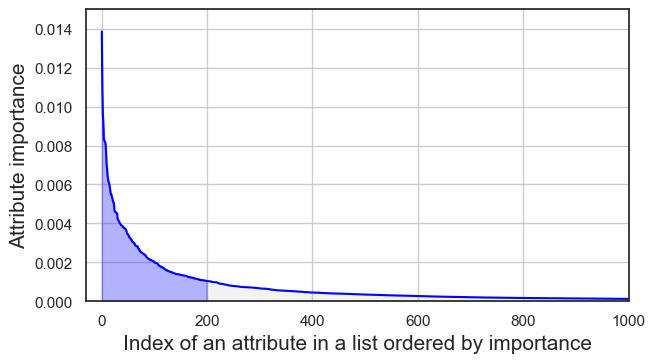

In [28]:
plt.figure(4, figsize=(7, 4))
sns.set_theme(style='white')
plt.plot(mer_imp_pairs[['Importance']].to_numpy().flatten(), color='blue')
plt.xlim([-30, 1000])
plt.ylim([0, 0.015])
plt.grid(True)
plt.fill_between(np.arange(200), mer_imp_pairs[['Importance']].to_numpy().flatten()[:200], 0, color='blue', alpha=.3)
plt.fill_between(np.arange(800)+200, mer_imp_pairs[['Importance']].to_numpy().flatten()[200:1000], 0, color='gray', alpha=.1)
plt.xlabel('Index of an attribute in a list ordered by importance', fontsize=15)
plt.ylabel('Attribute importance', fontsize=15)
plt.subplots_adjust(bottom=0.15)
plt.savefig('imgs/AttrDist.pdf', bbox_inches='tight')
plt.show()